# Merge-based spMspM

This is an example of A-stationary/row-major (Gusstavson) spM-spM, using a merge based accelerator.

First, include some libraries

In [1]:
# Begin - startup boilerplate code

import pkgutil

if 'fibertree_bootstrap' not in [pkg.name for pkg in pkgutil.iter_modules()]:
  !python3 -m pip  install git+https://github.com/Fibertree-project/fibertree-bootstrap --quiet

# End - startup boilerplate code


from fibertree_bootstrap import *
fibertree_bootstrap(style="tree", animation="movie")

interactive(children=(Dropdown(description='style', options=('tree', 'uncompressed', 'tree+uncompressed'), val…

Button(description='Run all cells below', style=ButtonStyle())

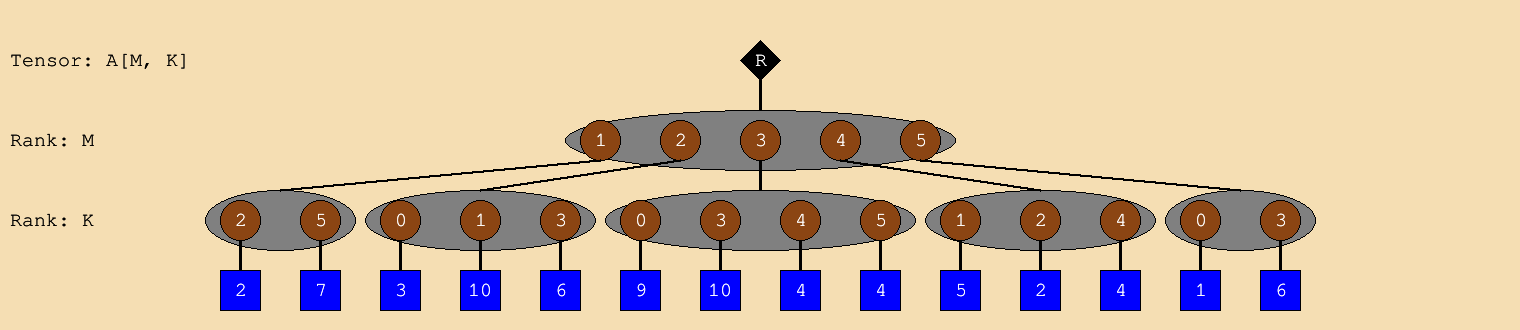

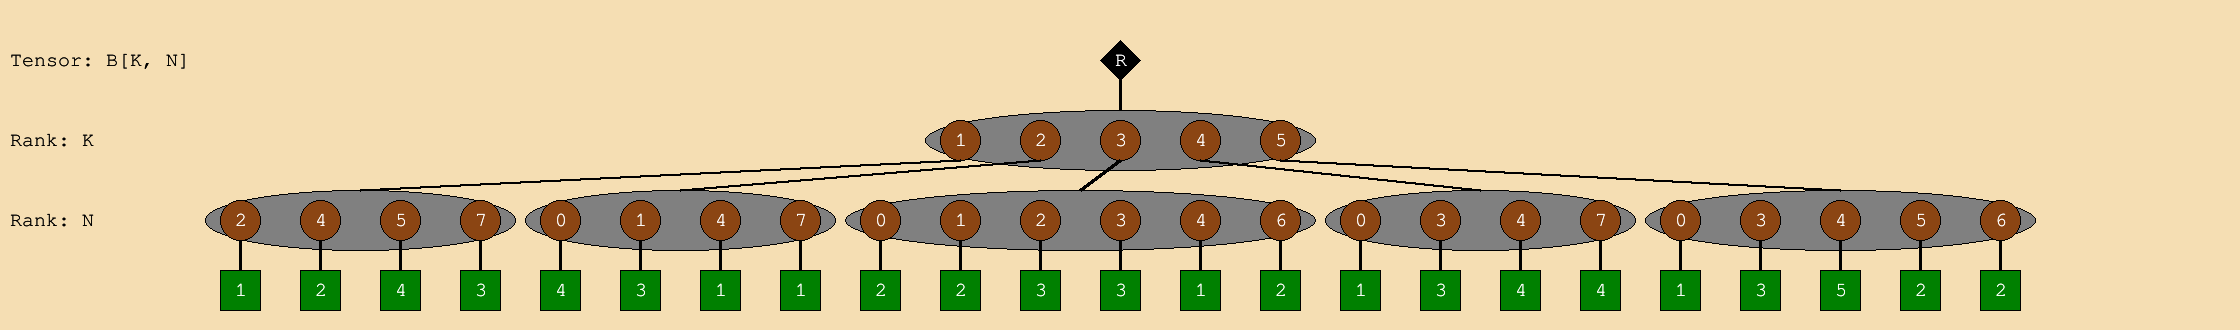

In [2]:
M = 6
K = 6
#N = 6
N = 8
seed = 20

a = Tensor.fromRandom(["M", "K"], [M, K], [0.9, 0.4], 10, seed=seed)
a.setColor("blue").setName("A")
displayTensor(a)

#b = Tensor.fromRandom(["K", "N"], [K, N], [0.7, 0.8], 5, seed=seed)
b = Tensor.fromRandom(["K", "N"], [K, N], [0.7, 0.6], 5, seed=seed)
b.setColor("green").setName("B")
displayTensor(b)



## A-stationary/row-major spMspM

Basic algorithm. This code corresponds to a simple version of MatRaptor, and has the following properties:

- The `A` tensor is travered in a concordant fashion.
- The k fibers of the `B` tensor are travered sequentially but those fibers are repeatedly fetched from memory
- The outputs are create a fiber at a time

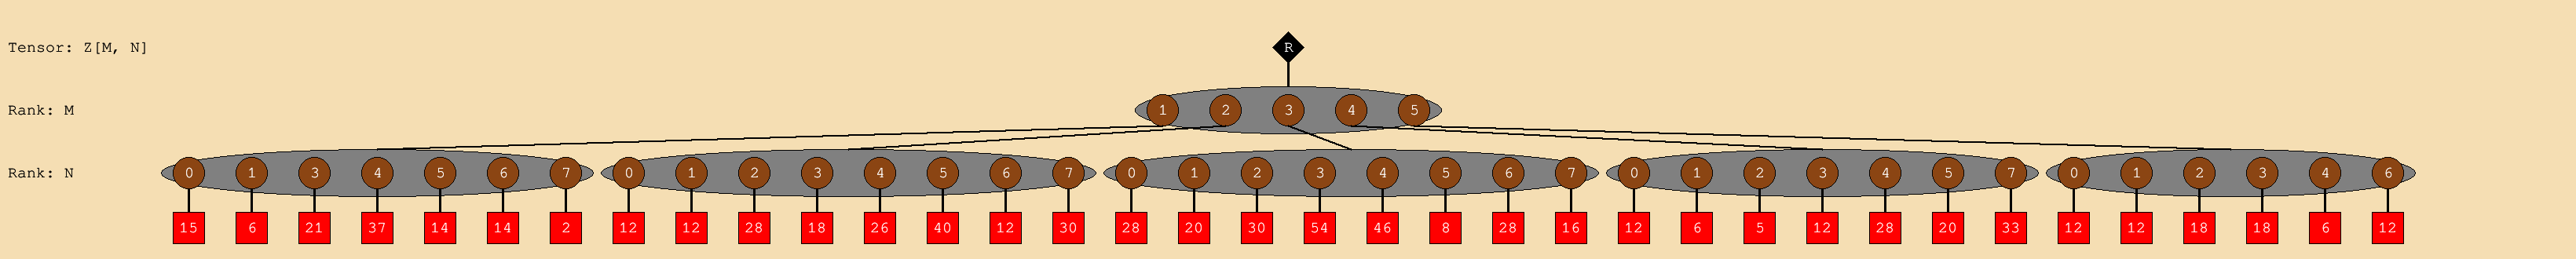

  0%|          | 0/54 [00:00<?, ?it/s]

In [3]:
z = Tensor(rank_ids=["M", "N"], shape=[M,N])
z.setName("Z")

a_m = a.getRoot()
b_k = b.getRoot()
z_m = z.getRoot()

canvas = createCanvas(a, b, z)

for m, (z_n, a_k) in z_m << a_m:
    for k, (a_val, b_n) in a_k & b_k:
        for n, (z_ref, b_val) in z_n << b_n:
            z_ref += a_val * b_val
            canvas.addFrame((m, k), (k, n), (m, n))

displayTensor(z)
displayCanvas(canvas)

## Illustrate Merge

An essential component of Gamma is a merge operation, which essentially does a merge sort of the elements of the fibers of the second rank of a tensor.  The following code illustrates the operation of a merger step-by-step and shows how it takes one element a cycle from one of the fibers in the second rank of `B` to form the output. 

Things to observe:
- All the elements in the `b_n` fibers that are candiates for consumption (in a cycle) are highlighted.
- Each cycle an element of a `b_n` fiber is consumed and inserted into the output, the next element in that fiber becomes a candidate for consumption in the next cycle
- The coordinates in the elements consumed from the `b` tensors are reversed when the element is inserted in to the `b_merged` tensor 
- Insertion into the `b_merged` tensor is concordant.
- In the end, the `b_merged` tensor is identical to the `b` tensor with its ranks swapped.

  0%|          | 0/25 [00:00<?, ?it/s]

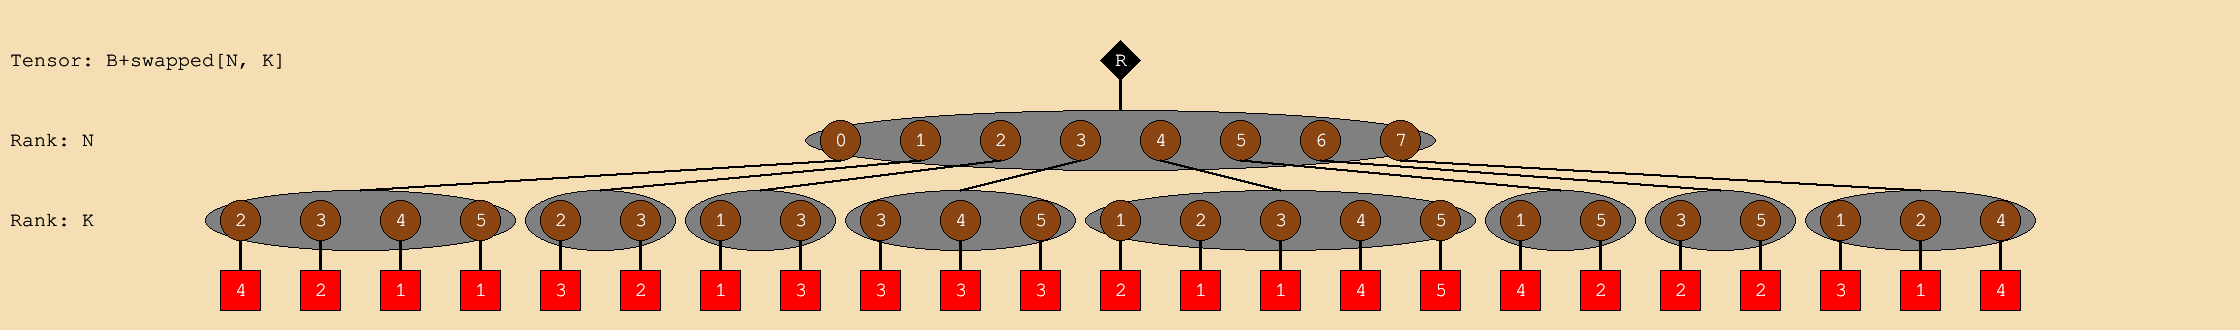

In [4]:
b_merged = Tensor(rank_ids=["N", "K"], shape=[N, K], name="B_merged")

#
# Get root fibers
#
b_k = b.getRoot()
b_merged_n = b_merged.getRoot()

#
# We treat each fiber in the second rank of `B` as a queue feeding the merge unit
# Position of head of queue for each fiber
#
b_n_queue_head_pos = len(b_k) * [0]

canvas = createCanvas(b, b_merged)

cycle = 0

element_dequeued = True

while element_dequeued:

    element_dequeued = False
    n_found = 100000                # Essentially +infinity
    
    #
    # Try to find an element at the head of a queue to dequeue
    #
    for k_pos,(k, b_n) in enumerate(b_k):
        
        #
        # Get position of head of queue (quitting if are done with the fiber)
        #
        b_n_pos_current = b_n_queue_head_pos[k_pos]
        if b_n_pos_current >= len(b_n):
            continue
            
        n_element = b_n[b_n_pos_current]

        canvas.addActivity((k, n_element.coord),
                           (0,0),                     # Hack to avoid bug...
                           spacetime=(0, (cycle,)))

        #
        # Remember the information for the potential eleemnt to be consumed
        #
        if  n_element.coord < n_found:
            element_dequeued = True
            k_pos_found = k_pos
            k_found = k
            n_found = n_element.coord
            n_found_value = n_element.payload

    #
    # Process the element to be dequeued
    #
    if element_dequeued:
        #
        # Insert dequeued element into output tensor
        #
        b_merged_element = b_merged.getPayloadRef(n_found, k_found)
        b_merged_element <<= n_found_value
    
        b_n_queue_head_pos[k_pos_found] += 1
    
        canvas.addActivity((k_found, n_found),
                           (n_found, k_found),
                           spacetime=(1, (cycle,)))

    cycle += 1
    
    
displayCanvas(canvas)
displayTensor(b.swapRanks().setColor("red"))


## Merge-based - with infinite merger

Using an append to add swapped ranks into "ba" tensor

In [ ]:
z = Tensor(rank_ids=["M", "N"], shape=[M,N])
z.setName("Z")

ba = Tensor(rank_ids=["M", "N", "K"])
ba.setColor("purple")
ba.setName("BA")

b_swapped = b.swapRanks()

a_m = a.getRoot()
b_k = b.getRoot()
ba_m = ba.getRoot()
z_m = z.getRoot()

canvas = createCanvas(a, b, b_swapped, ba, z)

for m, (z_n, a_k) in z_m << a_m: # M-dimension parallelism

    # Leader-follower intersection (a == leader)
    ba_k1 = b_k & a_k

    # Implemented with a merger and pipelined with next loop 
    ba_n = ba_k1.swapRanks()
    
    # Just for visualization
    ba_m.append(m, ba_n)
    
    for n, (z_ref, ba_k) in z_n << ba_n:
        for k, (b_val, a_val) in ba_k:
            z_ref += a_val * b_val
            canvas.addFrame((m, k), (k, n), (n, k), (m, n, k), (m, n))

displayTensor(z)
displayCanvas(canvas)

Basically the same code as above but creating the intersection fiber ab_k rather than ba_k. In this case, the second element of the intersection tuple is a Fiber and the swapRanks() was failing because of a problem in flattenRanks(). This is a test that those problems have been fixed...

In [ ]:
z = Tensor(rank_ids=["M", "N"], shape=[M,N])
z.setName("Z")

ab = Tensor(rank_ids=["M", "N", "K"])
ab.setColor("purple")
ab.setName("AB")

b_swapped = b.swapRanks()

a_m = a.getRoot()
b_k = b.getRoot()
ab_m = ab.getRoot()
z_m = z.getRoot()

canvas = createCanvas(a, b, b_swapped, ab, z)

for m, (z_n, a_k) in z_m << a_m: # M-dimension parallelism

    ab_k1 = a_k & b_k

    # Implemented with a merger and pipelined with next loop
    ab_n = ab_k1.swapRanks()
    
    # Just for visualization
    ab_m.append(m, ab_n)
    
    for n, (z_ref, ab_k) in z_n << ab_n:
        for k, (a_val, b_val) in ab_k:
            z_ref += a_val * b_val
            canvas.addFrame((m, k), (k, n), (n, k), (m, n, k), (m, n))

displayTensor(z)
displayCanvas(canvas)

## More Gamma-like implementation

Still assumes an infinite merger (i.e., that supports an arbitrary number of k-fibers of B), but it shows these steps/behaviors:

- Fetching  the relevant (i.e., "active") `k` fibers of `B` (from the fiber cache) based on the non-zeros in `A`.
- The "intersection" used to fetch those fiber is leader-follower with a fiber of `A` (`a_k`) as leader.
- Swapping the ranks of the `B_active` tensor comprised of those "active" fibers, which is achieved with a **merge** unit.
- Concordant traversal of the swapped `B_active` tensor contributing to outputs for one `n` at at time.
- Note that the traversal of the swapped `B_active` tensor is sequential in each active k-fibers of the original `B_active` tensor.
- The "intersection" of `k`s during that traversal is leader-follower with a fiber of `B` as leader.
- Accesses to `A` are all contrained to a single fiber at a time (i.e., the currently active a_k fiber)

In [ ]:

z = Tensor(rank_ids=["M", "N"], shape=[M,N])
z.setName("Z")

# For visualization
b_swapped = b.swapRanks()

a_m = a.getRoot()
b_k = b.getRoot()
z_m = z.getRoot()

canvas = createCanvas(a, b, b_swapped, z)

#
# Traverse the M rank of A and Z.
# In Gamma this is parallelized into multiple parallel PEs
# with M-dimension parallelism
#
for m, (z_n, a_k) in z_m << a_m:
    #
    # Create a tensor of the "active" subset of `B`
    # consisting of the b_k fibers with non-zeros k's in a_k,
    # using a leader-follower intersection (leader==a)
    # This "b_active" tensor is held in the Gamma fiber cache.
    #
    b_active_k = a_k & b_k
    b_active_k.updatePayloads(lambda p: p.value[1])
    #
    # Reorder the b_active tensor to process in "k-fastest" order.
    # Implemented in Gamma with a merger and pipelined with next loop
    #
    b_swapped_n = b_active_k.swapRanks()
    
    for n, (z_ref, b_swapped_k) in z_n << b_swapped_n:
        #
        # The following intersection is leader-follower (leader==b)
        #
        for k, (a_val, b_val) in a_k & b_swapped_k:
            z_ref += a_val * b_val
            #
            # Animiation control
            #
            # Show active b_k fibers, i.e., active fibers in fiber cache
            #
            canvas.addActivity((m,),
                               [(k,) for k in a_k.coords],
                               [(n,k) for k in a_k.coords for n in b_swapped_n.coords],
                               (),
                               spacetime=(0,(m,n,k)))
            #
            # Show current compute
            #
            canvas.addActivity((m, k), (k, n), (n, k), (m, n),
                                spacetime=(1, (m,n,k)))

displayTensor(z)
displayCanvas(canvas)

## Gamma-like (alternate visualization)

Combine cycles for multiple "k"s into a single frame.

In [ ]:

z = Tensor(rank_ids=["M", "N"], shape=[M,N])
z.setName("Z")

# For visualization
b_swapped = b.swapRanks()

a_m = a.getRoot()
b_k = b.getRoot()
z_m = z.getRoot()

canvas = createCanvas(a, b, b_swapped, z)

#
# Traverse the M rank of A and Z.
# In Gamma this is parallelized into multiple parallel PEs
# with M-dimension parallelism
#
for m, (z_n, a_k) in z_m << a_m:
    #
    # Create a tensor of the "active" subset of `B`
    # consisting of the b_k fibers with non-zeros k's in a_k,
    # using a leader-follower intersection (leader==a)
    # This "b_active" tensor is held in the Gamma fiber cache.
    #
    b_active_k = a_k & b_k
    b_active_k.updatePayloads(lambda p: p.value[1])
    #
    # Reorder the b_active tensor to process in "k-fastest" order.
    # Implemented in Gamma with a merger and pipelined with next loop
    #
    b_swapped_n = b_active_k.swapRanks()
    
    for n, (z_ref, b_swapped_k) in z_n << b_swapped_n:
        #
        # The following intersection is leader-follower (leader==b)
        #
        for k, (a_val, b_val) in a_k & b_swapped_k:
            z_ref += a_val * b_val
            #
            # Animiation control
            #
            # Show active b_k fibers, i.e., active fibers in fiber cache
            #
            canvas.addActivity((m,),
                               [(k,) for k in a_k.coords],
                               [(n,k) for k in a_k.coords for n in b_swapped_n.coords],
                               (0,0),                       # Hack to avoid bug - should be ()
                               spacetime=(0,(m,n)))
            #
            # Show current compute
            #
            canvas.addActivity((m, k), (k, n), (n, k), (m, n),
                                spacetime=(k, (m,n)))

displayTensor(z)
displayCanvas(canvas)